# Analyze speakers

In [404]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [405]:
df = pd.read_csv('../data/euroleaks/prepared.csv')
df.head()

,speaker,speech,timestamp,date
0,Jeroen Dijsselbloem,… of your responses or questions. And can I fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,Speaker 2,"Uh, yes, uh, thank you, Jeroen. Well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,Michael Noonan,Michael Noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,Speaker 2,"Uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,Speaker 3,Has entered the conference.,1900-01-01 00:01:33,2015-02-24 00:00:00


### handle missing speaker

In [406]:
df[df.speaker.isnull()]

,speaker,speech,timestamp,date
1394,NaN,"Jeroen Dijsselbloem\nNow, let’s see who is on ...",NaN,2015-07-01 00:00:00


In [407]:
df.speaker.loc[df.speaker.isnull()] = 'jeroen dijsselbloem'

## inspect unique speakers

In [408]:
# strip and make lowercase
df.speaker = df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s)

In [409]:
# display all the names

for s in df.speaker.unique():
    if 'speaker' not in s:
        print(s)

jeroen dijsselbloem
michael noonan
pierre moscovici
mario draghi
wolfgang schäuble
christine lagarde
yanis varoufakis
yanis [not varoufakis]
luis de guindos
maria luís
marco buti
thomas wieser
declan costello
computer
benoit couré
paul thomsen
greek representative
thomas
benoit cœuré
nikos theocarakis
irina
irana
nabil
tooma
tropa
ricci
hans
paul
klaus regling
peter kažimír
martin
hans jörg schelling
dušan mramor
michel sapin
pier carlo padoan
edward scicluna
rimantas šadžius
poul thomsen
alexander stubb
inaudible
yanis varoufakis [privately]
johan van overtveldt
maria luís albuquerque
benoît cœuré
kian
male
group
johan
maria luis albuquerque
harris georgiades
translator
michel
luis pierre
luis
peter kazimir
wolfgang schauble
wolfgang


### drop some rows
For instance those which transcribe words said by computer.

In [410]:
#df[df.speech == 'Has entered the conference.']

In [411]:
df = df[df.speech != 'Has entered the conference.']

In [412]:
#df[df.speaker == 'group']

In [413]:
df = df[df.speaker != 'group']

In [414]:
#df[df.speaker == 'inaudible']

In [415]:
df = df[df.speaker != 'inaudible']

In [416]:
#for row in df[df.speaker == 'inaudible'].iterrows():
#    print(row[1].speech)
#    print()

Unidentified speakers:

In [445]:
search_term = 'speaker'

for speaker in df.speaker.apply(lambda s: s.strip().lower() if not pd.isnull(s) else s).unique():
    if not pd.isnull(speaker) and search_term in speaker:
        print(speaker)
        pass

speaker 2
speaker 5
speaker 9
speaker 10
speaker 6
speaker 7
speaker 8
speaker 11
speaker 12
speaker 13
speaker 14
speaker 19
speaker 1
speaker 3
unidentified speaker
speaker 16
speaker 20
speaker 4
speaker 17
speaker 18
speaker 21
speaker


### manually construct mapping of different version of the same name to that name
Note that there is Thomas Wieser and just Thomas, two distinct persons.

In [418]:
amend_names = {
    'wolfgang schäuble': [
        'wolfgang schäuble',
        'wolfgang schauble',
        'wolfgang'
    ],
    'peter kažimír': [
        'peter kažimír',
        'peter kazimir'
    ],
    'michel sapin': [
        'michel sapin',
        'michel'
    ],
    'maria luís albuquerque': [
        'maria luís albuquerque',
        'maria luís',
        'maria luis albuquerque'
    ],
    'johan van overtveldt': [
        'johan van overtveldt',
        'johan'
    ],
    'benoît cœuré': [
        'benoît cœuré',
        'benoit couré',
        'benoit cœuré'
    ],
    'hans jörg schelling': [
        'hans jörg schelling',
        'hans'
    ],
    'poul mathias thomsen': [
        'paul thomsen',
        'paul',
        'poul thomsen'
    ],
    'yanis varoufakis': [
        'yanis varoufakis',
        'yanis varoufakis [privately]'
    ],
    'luis de guindos': [
        'luis de guindos',
        'luis'
    ],
    'irina': [
        'irina',
        'irana'
    ],
    'jānis reirs': [
        'yanis [not varoufakis]'
    ],
    'luca antonio ricci': [
        'ricci'
    ],
    'thomas steffen': [
        'thomas'
    ]
}

In [419]:
# invert dict
amend_names_inv = {value: key for key,values in amend_names.items() for value in values}

In [420]:
# amend speaker names
df.speaker = df.speaker.apply(lambda s: amend_names_inv[s] if s in amend_names_inv.keys() else s)

In [421]:
for speaker in df.speaker.unique():
    if 'speaker' not in speaker:
        #print(speaker)
        pass

## word count by speaker

In [422]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.speech)

X.toarray().shape

(1508, 5264)

In [423]:
df['wordcount'] = X.toarray().sum(axis=1)

In [424]:
wc_by_speaker = df.groupby('speaker')['wordcount'].sum()

In [425]:
wc_by_speaker.describe()

count       61.000000
mean      1711.868852
std       3878.494358
min          5.000000
25%        254.000000
50%        610.000000
75%       1783.000000
max      24253.000000
Name: wordcount, dtype: float64

### all speakers

In [426]:
is_named = wc_by_speaker.index.to_series().apply(lambda s: 'speaker' not in s).to_numpy()

cmap = np.array([u'#ff7f0e', u'#1f77b4'])

color = cmap[is_named.astype(int)]

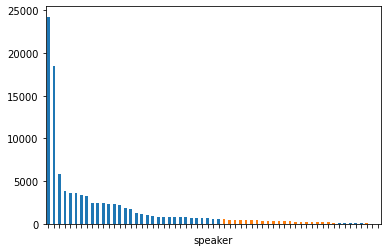

In [427]:
ax = wc_by_speaker.sort_values(ascending=False).plot.bar(color=color)
labels = ax.set_xticklabels([])

### all named speakers

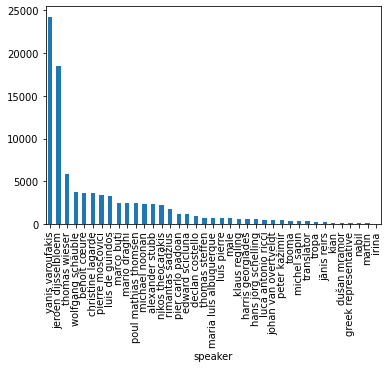

In [428]:
ax = wc_by_speaker[is_named].sort_values(ascending=False).plot.bar()
#labels = ax.set_xticklabels([])

### all unnamed speakers

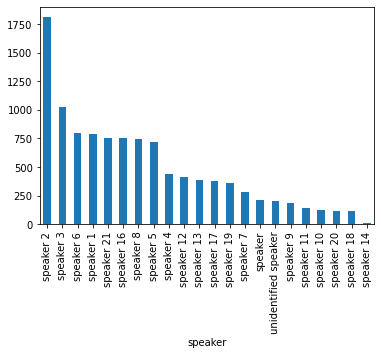

In [429]:
ax = wc_by_speaker[np.invert(is_named)].sort_values(ascending=False).plot.bar()
#labels = ax.set_xticklabels([])

### proportion of unnamed speakers

In [430]:
x = wc_by_speaker[np.invert(is_named)].sum() / wc_by_speaker.sum()

print(f'{np.round(x*100,4)} % of words belong to unnamed speakers.')

10.2974 % of words belong to unnamed speakers.


## word count by entity
Manually map speaker to entity.

In [431]:
# TODO maybe update after you get an answer to your email

# missing:
# estonia (Maris Lauri, Sven Sester)
# luxembourg (Pierre Gramegna)


speaker_to_entity = {
    'jeroen dijsselbloem': 'eurogroup president', # the netherlands
    'michael noonan': 'ireland',
    'pierre moscovici': 'european commission',
    'mario draghi': 'ecb',
    'wolfgang schäuble': 'germany',
    'thomas steffen': 'germany', # State Secretary at the Federal Ministry of Finance under Schauble
    'christine lagarde': 'imf',
    'yanis varoufakis': 'greece',
    'luis de guindos': 'spain',
    'maria luís albuquerque': 'portugal',
    'marco buti': 'european commission',
    'thomas wieser': 'efc', # economic and financial committee
    'declan costello': 'european commission', #dg ecfin
    'benoît cœuré': 'ecb',
    'poul mathias thomsen': 'imf',
    'greek representative': 'greece',
    'nikos theocarakis': 'greece',
    'hans jörg schelling': 'austria',
    'klaus regling': 'esm', # head of european stability mechanism
    'peter kažimír': 'slovakia',
    'dušan mramor': 'slovenia',
    'michel sapin': 'france',
    'translator': 'france',
    'pier carlo padoan': 'italy',
    'edward scicluna': 'malta',
    'rimantas šadžius': 'lithuania',
    'alexander stubb': 'finland', # from May 29
    'tooma': 'finland', # based on saying they have two and a half weeks until elections on April 1
    'johan van overtveldt': 'belgium',
    'harris georgiades': 'cyprus',
    'luis pierre': 'european commission',
    'jānis reirs': 'latvia',
    'luca antonio ricci': 'imf'
}

#### still don't know who these people represent...

In [432]:
for speaker in df.speaker.unique():
    if not ('speaker' in speaker or speaker in speaker_to_entity.keys()):
        print(speaker)
        print(df[df.speaker == speaker].wordcount.sum())
        print()
        pass

irina
27

nabil
87

tropa
254

martin
73

kian
165

male
639



In [442]:
df[df.speaker == 'nabil'].date.unique()

array(['2015-04-01 00:00:00'], dtype=object)

In [443]:
for row in df[df.speaker == 'nabil'].iterrows():
    print(row[1].speech)
    print()

[inaudible 00:45:06] It’s [Nabil 00:45:08]. Yes, uh, my questions, um, because, um, uh, we have been talking about Nikos measures which were submitted by the Greek side. Um, frankly they have been already news in a lot of m- media, so, um, it would be really very helpful to get this list of measures so that we actually know what we are talking about. And I understand from Nikos that he’s going to send to the members of the, the EWG which would be very helpful.



In [433]:
# add column for entity, label unassigned as unknown
df['entity'] = df.speaker.apply(lambda s: speaker_to_entity[s] if s in speaker_to_entity.keys() else 'unkown')

In [434]:
wc_by_entity = df.groupby('entity')['wordcount'].sum()

<AxesSubplot:xlabel='entity'>

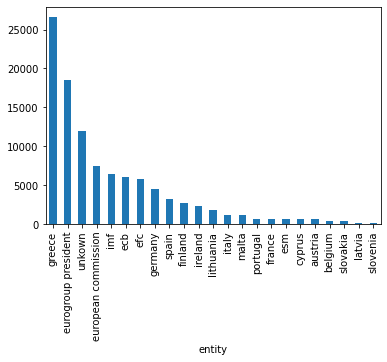

In [435]:
wc_by_entity.sort_values(ascending=False).plot.bar()

#### group institutions together

In [436]:
wcent = pd.DataFrame({
    'total': wc_by_entity,
    'countries': wc_by_entity,
    'european commission': np.zeros(wc_by_entity.size, dtype=int),
    'efc': np.zeros(wc_by_entity.size, dtype=int),
    'ecb': np.zeros(wc_by_entity.size, dtype=int),
    'esm': np.zeros(wc_by_entity.size, dtype=int),
    'imf': np.zeros(wc_by_entity.size, dtype=int)
})

wcent.loc['institutions'] = np.array([
    0,
    0,
    wc_by_entity.loc['european commission'],
    wc_by_entity.loc['efc'],
    wc_by_entity.loc['ecb'],
    wc_by_entity.loc['esm'],
    wc_by_entity.loc['imf']
])

wcent['countries'][(wcent.index.to_numpy() == 'efc') | (wcent.index.to_numpy() == 'ecb') | (wcent.index.to_numpy() == 'esm') |(wcent.index.to_numpy() == 'imf') | (wcent.index.to_numpy() == 'european commission')] = 0

<AxesSubplot:xlabel='entity'>

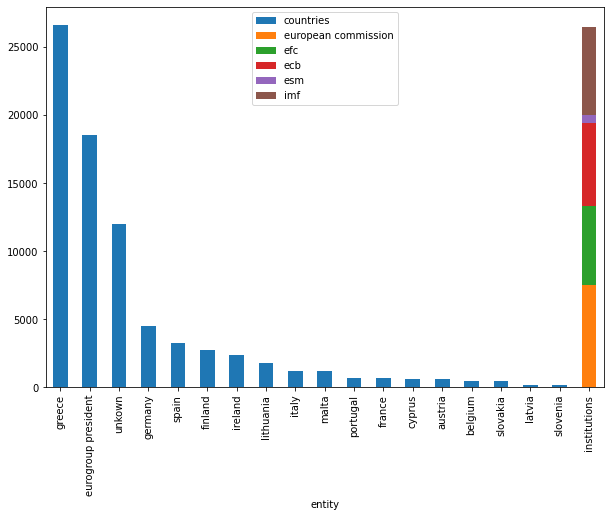

In [437]:
wcent.sort_values(by='total', ascending=False).drop(columns=['total'], index=['european commission', 'efc', 'ecb', 'esm', 'imf']).plot.bar(stacked=True, figsize=(10,7))